# Implementation and Analysis of Grover’s Algorithm on a Small Datasets Using Qiskit

**Course:** TÖL031M Quantum Computing and Quantum Cryptography  
**Group Members:** Iftejar Miah Viki, Gísli Már Guðmundsson

**Date:** November 2025  

This notebook demonstrates the implementation of **Grover’s Quantum Search Algorithm** on a small datasets using Qiskit.  
We compare the performance of the quantum search with a classical linear search, Noise and visualize the results.

In [1]:
# Importing necessary libraries
%matplotlib inline
import csv
import math
import time
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library import MCXGate
from qiskit import transpile
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
import pandas as pd

Step 1: Create the Dataset

1.1 Dataset for N=2^3 = 8 (People_8.csv)

In [2]:
rows = [
    ["Name", "Phone", "Address"],
    ["Alice", "5551234", "Reykjavik"],
    ["Bob", "5559876", "Akureyri"],
    ["Carol", "5551111", "Hafnarfjordur"],
    ["David", "5552222", "Kopavogur"],
    ["Emma", "5553333", "Reykjanesbaer"],
    ["Frank", "5554444", "Selfoss"],
    ["Grace", "5555555", "Egilsstadir"],
    ["Helen", "5556666", "Isafjordur"],
]

with open("people_8.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("people8.csv created")

people8.csv created


1.2 Dataset for N=2^4 = 16 (People_16.csv)

In [3]:
rows_16 = [
    ["Name", "Phone", "Address"],
    ["Alice", "5551234", "Reykjavik"],
    ["Bob", "5559876", "Akureyri"],
    ["Carol", "5551111", "Hafnarfjordur"],
    ["David", "5552222", "Kopavogur"],
    ["Emma", "5553333", "Reykjanesbaer"],
    ["Frank", "5554444", "Selfoss"],
    ["Grace", "5555555", "Egilsstadir"],
    ["Helen", "5556666", "Isafjordur"],
    ["Ian", "5557777", "Gardabaer"],
    ["Julia", "5558888", "Reykjavik"],
    ["Karl", "5559999", "Akureyri"],
    ["Laura", "5550001", "Hafnarfjordur"],
    ["Mark", "5550002", "Kopavogur"],
    ["Nina", "5550003", "Reykjanesbaer"],
    ["Oscar", "5550004", "Selfoss"],
    ["Paula", "5550005", "Egilsstadir"],
]

with open("people_16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(rows_16)

print("Updated people_16.csv with 16 entries.")

Updated people_16.csv with 16 entries.


1.3 Dataset for N=2^5 = 32 (People_32.csv)

In [4]:
rows = [
    ["Name", "Phone", "Address"],
    ["Alice", "5552001", "Reykjavik"],
    ["Bob", "5552002", "Akureyri"],
    ["Carol", "5552003", "Hafnarfjordur"],
    ["David", "5552004", "Kopavogur"],
    ["Emma", "5552005", "Reykjanesbaer"],
    ["Frank", "5552006", "Selfoss"],
    ["Grace", "5552007", "Egilsstadir"],
    ["Helen", "5552008", "Isafjordur"],
    ["Ian", "5552009", "Akranes"],
    ["Julia", "5552010", "Mosfellsbaer"],
    ["Karl", "5552011", "Gardabaer"],
    ["Laura", "5552012", "Saudarkrokur"],
    ["Matt", "5552013", "Hveragerdi"],
    ["Nina", "5552014", "Borgarnes"],
    ["Oscar", "5552015", "Husavik"],
    ["Paula", "5552016", "Blonduos"],
    ["Quinn", "5552017", "Vik"],
    ["Rafael", "5552018", "Egilsstadir"],
    ["Sara", "5552019", "Selfoss"],
    ["Tom", "5552020", "Akranes"],
    ["Una", "5552021", "Reykjavik"],
    ["Victor", "5552022", "Kopavogur"],
    ["Wendy", "5552023", "Akureyri"],
    ["Xander", "5552024", "Isafjordur"],
    ["Yara", "5552025", "Hafnarfjordur"],
    ["Zack", "5552026", "Mosfellsbaer"],
    ["Aron", "5552027", "Gardabaer"],
    ["Bella", "5552028", "Reykjanesbaer"],
    ["Chris", "5552029", "Hveragerdi"],
    ["Dora", "5552030", "Borgarnes"],
    ["Elli", "5552031", "Husavik"],
    ["Finn", "5552032", "Selfoss"],
]

with open("people_32.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("people_32.csv created")


people_32.csv created


Step 2: Load Dataset + Convert to Binary States

In [5]:
def load_people(filename):
    people = []
    with open(filename) as f:
        reader = csv.DictReader(f)
        for row in reader:
            people.append(row)
    return people


Binary mapping helper:

In [6]:
def index_to_binary(i, num_qubits):
    return format(i, f"0{num_qubits}b")

2.1 (Qubits = 3)

In [7]:
people_3 = load_people("people_8.csv")

print("=== 3-qubit dataset (N = {}) ===".format(len(people_3)))
for i, row in enumerate(people_3):
    basis_state = index_to_binary(i, num_qubits=3)
    print(i, basis_state, row["Name"], row["Phone"], row["Address"])

=== 3-qubit dataset (N = 8) ===
0 000 Alice 5551234 Reykjavik
1 001 Bob 5559876 Akureyri
2 010 Carol 5551111 Hafnarfjordur
3 011 David 5552222 Kopavogur
4 100 Emma 5553333 Reykjanesbaer
5 101 Frank 5554444 Selfoss
6 110 Grace 5555555 Egilsstadir
7 111 Helen 5556666 Isafjordur


2.2 (Qubits = 4)

In [8]:
people_4 = load_people("people_16.csv")

print("\n=== 4-qubit dataset (N = {}) ===".format(len(people_4)))
for i, row in enumerate(people_4):
    basis_state = index_to_binary(i, num_qubits=4)
    print(i, basis_state, row["Name"], row["Phone"], row["Address"])


=== 4-qubit dataset (N = 16) ===
0 0000 Alice 5551234 Reykjavik
1 0001 Bob 5559876 Akureyri
2 0010 Carol 5551111 Hafnarfjordur
3 0011 David 5552222 Kopavogur
4 0100 Emma 5553333 Reykjanesbaer
5 0101 Frank 5554444 Selfoss
6 0110 Grace 5555555 Egilsstadir
7 0111 Helen 5556666 Isafjordur
8 1000 Ian 5557777 Gardabaer
9 1001 Julia 5558888 Reykjavik
10 1010 Karl 5559999 Akureyri
11 1011 Laura 5550001 Hafnarfjordur
12 1100 Mark 5550002 Kopavogur
13 1101 Nina 5550003 Reykjanesbaer
14 1110 Oscar 5550004 Selfoss
15 1111 Paula 5550005 Egilsstadir


2.3 (Qubits = 5)

In [9]:
people_5 = load_people("people_32.csv")

print("\n=== 5-qubit dataset (N = {}) ===".format(len(people_5)))
for i, row in enumerate(people_5):
    basis_state = index_to_binary(i, num_qubits=5)
    print(i, basis_state, row["Name"], row["Phone"], row["Address"])


=== 5-qubit dataset (N = 32) ===
0 00000 Alice 5552001 Reykjavik
1 00001 Bob 5552002 Akureyri
2 00010 Carol 5552003 Hafnarfjordur
3 00011 David 5552004 Kopavogur
4 00100 Emma 5552005 Reykjanesbaer
5 00101 Frank 5552006 Selfoss
6 00110 Grace 5552007 Egilsstadir
7 00111 Helen 5552008 Isafjordur
8 01000 Ian 5552009 Akranes
9 01001 Julia 5552010 Mosfellsbaer
10 01010 Karl 5552011 Gardabaer
11 01011 Laura 5552012 Saudarkrokur
12 01100 Matt 5552013 Hveragerdi
13 01101 Nina 5552014 Borgarnes
14 01110 Oscar 5552015 Husavik
15 01111 Paula 5552016 Blonduos
16 10000 Quinn 5552017 Vik
17 10001 Rafael 5552018 Egilsstadir
18 10010 Sara 5552019 Selfoss
19 10011 Tom 5552020 Akranes
20 10100 Una 5552021 Reykjavik
21 10101 Victor 5552022 Kopavogur
22 10110 Wendy 5552023 Akureyri
23 10111 Xander 5552024 Isafjordur
24 11000 Yara 5552025 Hafnarfjordur
25 11001 Zack 5552026 Mosfellsbaer
26 11010 Aron 5552027 Gardabaer
27 11011 Bella 5552028 Reykjanesbaer
28 11100 Chris 5552029 Hveragerdi
29 11101 Dora 5552

Step 3: Classical search function

In [10]:
def classical_search_people(people_list, target_name):
    checks = 0
    start = time.perf_counter()
    for i, row in enumerate(people_list):
        checks += 1
        if row["Name"] == target_name:
            end = time.perf_counter()
            return i, checks, (end - start)
    end = time.perf_counter()
    return None, checks, (end - start)


def find_target_index(people_list, target_name):
    for i, row in enumerate(people_list):
        if row["Name"] == target_name:
            return i
    return None

Step 4: Selecting the target

4.1 (Qubit=3)

In [11]:
target_name_3 = "Carol"
target_index_3 = find_target_index(people_3, target_name_3)
print("3-qubit target:", target_name_3)
print("Index:", target_index_3)
print("Binary:", index_to_binary(target_index_3, 3))

3-qubit target: Carol
Index: 2
Binary: 010


4.2 (Qubit=4)

In [12]:
target_name_4 = "Paula"
target_index_4 = find_target_index(people_4, target_name_4)
print("\n4-qubit target:", target_name_4)
print("Index:", target_index_4)
print("Binary:", index_to_binary(target_index_4, 4))


4-qubit target: Paula
Index: 15
Binary: 1111


4.3 (Qubit=5)

In [13]:
target_name_5 = "Yara"
target_index_5 = find_target_index(people_5, target_name_5)
print("\n5-qubit target:", target_name_5)
print("Index:", target_index_5)
print("Binary:", index_to_binary(target_index_5, 5))


5-qubit target: Yara
Index: 24
Binary: 11000


Step 5: qubit Oracle

In [14]:
def grover_oracle(bitstring: str) -> QuantumCircuit:
    n = len(bitstring)
    qc = QuantumCircuit(n, name="Oracle")

    for i, bit in enumerate(bitstring):
        if bit == "0":
            qc.x(i)

    control_qubits = list(range(n - 1))
    target_qubit = n - 1

    qc.h(target_qubit)
    qc.append(MCXGate(num_ctrl_qubits=n - 1), control_qubits + [target_qubit])
    qc.h(target_qubit)

    for i, bit in enumerate(bitstring):
        if bit == "0":
            qc.x(i)

    return qc


Running for Qubits 3, 4 and 5

In [15]:
target_state_3 = index_to_binary(target_index_3, 3)
oracle_3 = grover_oracle(target_state_3)

target_state_4 = index_to_binary(target_index_4, 4)
oracle_4 = grover_oracle(target_state_4)

target_state_5 = index_to_binary(target_index_5, 5)
oracle_5 = grover_oracle(target_state_5)

Step 6: Diffuser

In [16]:
def diffuser(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Diffuser")


    qc.h(range(n))
    qc.x(range(n))


    control_qubits = list(range(n - 1))
    target_qubit = n - 1

    qc.h(target_qubit)
    qc.append(MCXGate(num_ctrl_qubits=n - 1), control_qubits + [target_qubit])
    qc.h(target_qubit)


    qc.x(range(n))
    qc.h(range(n))

    return qc


6.1 Making Deffusers for 3, 4 and 5 qubits

In [17]:
diffuser_3 = diffuser(3)
diffuser_4 = diffuser(4)
diffuser_5 = diffuser(5)


Step 7: Code for building the Grover´s Circuit´s

In [18]:
def build_grover(num_qubits: int, target_state: str) -> QuantumCircuit:
    N = 2 ** num_qubits
    iterations = math.floor(math.pi / 4 * math.sqrt(N))
    print(f"Grover iterations (N={N}, {num_qubits} qubits): {iterations}")

    qc = QuantumCircuit(num_qubits, num_qubits)

    qc.h(range(num_qubits))

    oracle_gate = grover_oracle(target_state).to_gate(label="Oracle")
    diffuser_gate = diffuser(num_qubits).to_gate(label="Diffuser")

    for _ in range(iterations):
        qc.append(oracle_gate, range(num_qubits))
        qc.append(diffuser_gate, range(num_qubits))

    qc.measure(range(num_qubits), range(num_qubits))

    return qc


Step 8: Build and display the circuit

8.1 3-Qubit Grover´s Circuit

Grover iterations (N=8, 3 qubits): 2


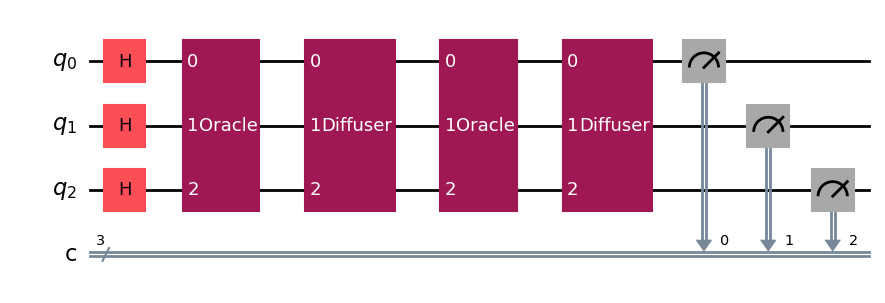

In [19]:
target_state_3 = index_to_binary(target_index_3, 3)
grover_circuit_3 = build_grover(3, target_state_3)
grover_circuit_3.draw("mpl")

8.2 4-Qubit Grover´s Circuit

Grover iterations (N=16, 4 qubits): 3


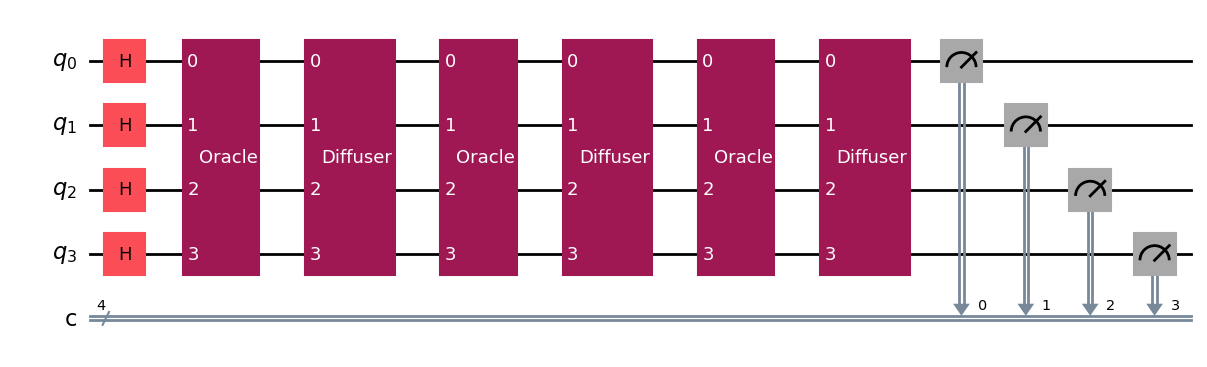

In [20]:
target_state_4 = index_to_binary(target_index_4, 4)
grover_circuit_4 = build_grover(4, target_state_4)
grover_circuit_4.draw("mpl")

8.3 5-Qubit Grover´s Circuit

Grover iterations (N=32, 5 qubits): 4


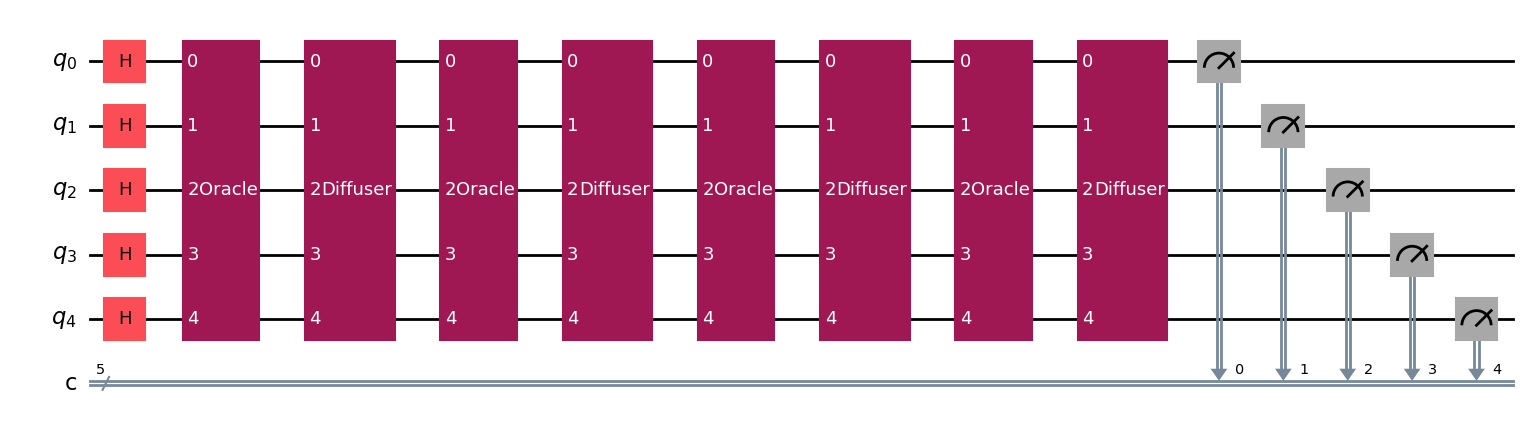

In [21]:
target_state_5 = index_to_binary(target_index_5, 5)
grover_circuit_5 = build_grover(5, target_state_5)
grover_circuit_5.draw("mpl")

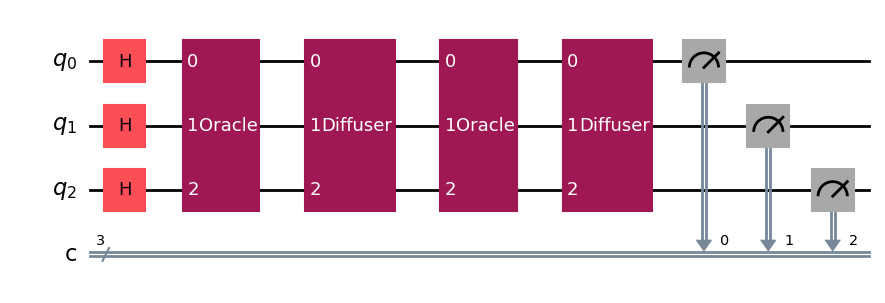

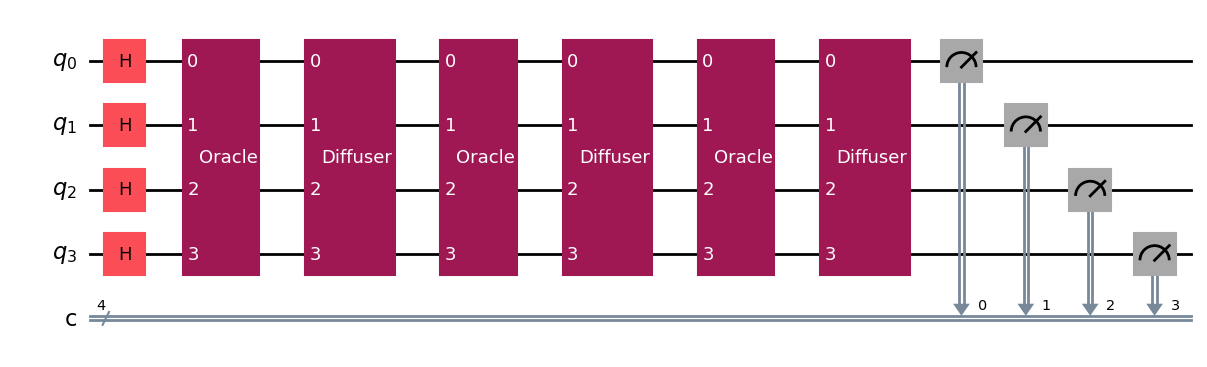

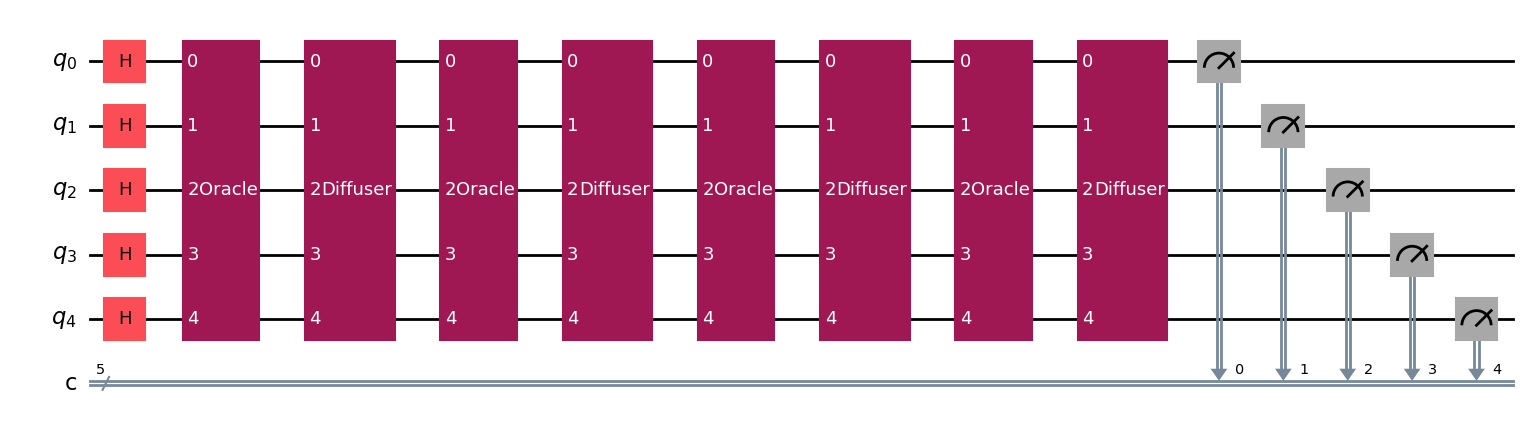

In [22]:
plt.show()

Step 9: Run ideal Grover simulation

Help Function

In [23]:
def run_grover_simulation(qc, target_state: str, simulator, shots: int = 1024):
    qc_sim = transpile(qc, simulator)

    start = time.perf_counter()
    result = simulator.run(qc_sim, shots=shots).result()
    elapsed = time.perf_counter() - start

    counts = result.get_counts()

    target_key = target_state[::-1]
    success_prob = counts.get(target_key, 0) / shots

    return elapsed, counts, success_prob



In [24]:
sim_ideal = AerSimulator()

shots = 1024

results_summary = []

9.1 3-Qubits

=== 3-qubit case (N=8) ===
Classical: idx=2, checks=3, time=0.0054 ms
Quantum ideal: time=178.3438 ms, success=0.961
Counts: {'001': 5, '100': 6, '110': 9, '101': 6, '111': 2, '011': 6, '000': 6, '010': 984}


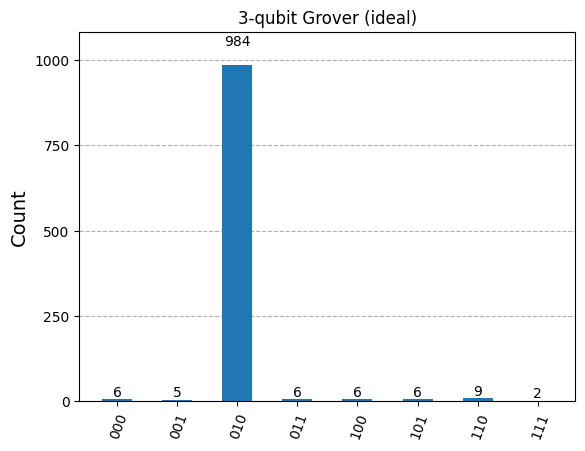

In [25]:
idx3, checks3, t_classical_3 = classical_search_people(people_3, target_name_3)
t_quantum_3, counts_ideal_3, success_3 = run_grover_simulation(
    grover_circuit_3, target_state_3, sim_ideal, shots=shots
)

print("=== 3-qubit case (N=8) ===")
print(f"Classical: idx={idx3}, checks={checks3}, time={t_classical_3*1000:.4f} ms")
print(f"Quantum ideal: time={t_quantum_3*1000:.4f} ms, success={success_3:.3f}")
print("Counts:", counts_ideal_3)
plot_histogram(counts_ideal_3, title="3-qubit Grover (ideal)")
plt.show()

results_summary.append({
    "num_qubits": 3,
    "N": len(people_3),
    "classical_checks": checks3,
    "classical_time_ms": t_classical_3 * 1000,
    "ideal_time_ms": t_quantum_3 * 1000,
    "ideal_success": success_3,
})

9.2 4-Qubits


=== 4-qubit case (N=16) ===
Classical: idx=15, checks=16, time=0.0135 ms
Quantum ideal: time=92.6452 ms, success=0.952
Counts: {'0001': 3, '1100': 2, '1111': 975, '0000': 2, '0010': 3, '0101': 4, '1001': 3, '1101': 4, '1000': 3, '0110': 1, '1110': 5, '1011': 7, '0111': 1, '0011': 2, '1010': 6, '0100': 3}


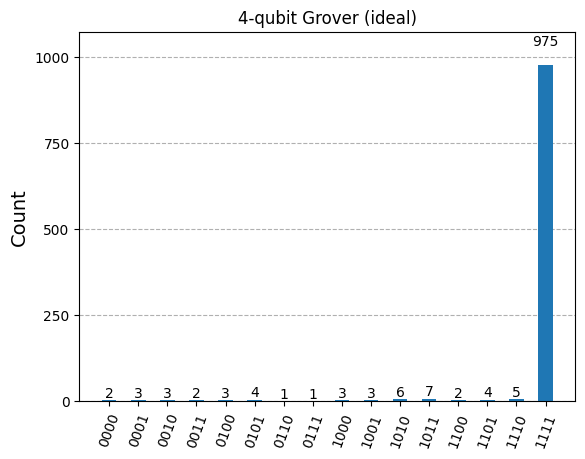

In [26]:
idx4, checks4, t_classical_4 = classical_search_people(people_4, target_name_4)
t_quantum_4, counts_ideal_4, success_4 = run_grover_simulation(
    grover_circuit_4, target_state_4, sim_ideal, shots=shots
)

print("\n=== 4-qubit case (N=16) ===")
print(f"Classical: idx={idx4}, checks={checks4}, time={t_classical_4*1000:.4f} ms")
print(f"Quantum ideal: time={t_quantum_4*1000:.4f} ms, success={success_4:.3f}")
print("Counts:", counts_ideal_4)
plot_histogram(counts_ideal_4, title="4-qubit Grover (ideal)")
plt.show()

results_summary.append({
    "num_qubits": 4,
    "N": len(people_4),
    "classical_checks": checks4,
    "classical_time_ms": t_classical_4 * 1000,
    "ideal_time_ms": t_quantum_4 * 1000,
    "ideal_success": success_4,
})

9.3 5-Qubits


=== 5-qubit case (N=32) ===
Classical: idx=24, checks=25, time=0.0169 ms
Quantum ideal: time=97.2318 ms, success=1.000
Counts: {'00011': 1024}


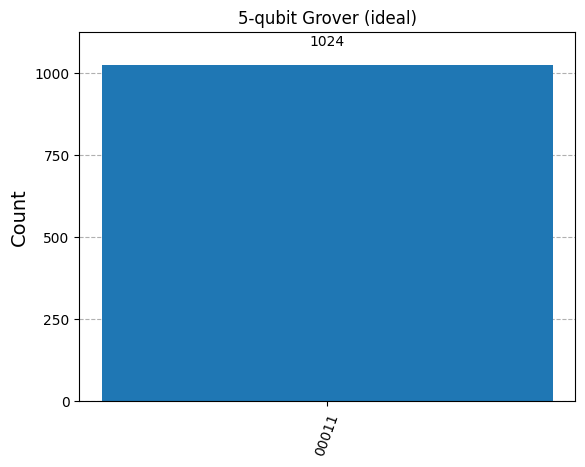

In [27]:
idx5, checks5, t_classical_5 = classical_search_people(people_5, target_name_5)
t_quantum_5, counts_ideal_5, success_5 = run_grover_simulation(
    grover_circuit_5, target_state_5, sim_ideal, shots=shots
)

print("\n=== 5-qubit case (N=32) ===")
print(f"Classical: idx={idx5}, checks={checks5}, time={t_classical_5*1000:.4f} ms")
print(f"Quantum ideal: time={t_quantum_5*1000:.4f} ms, success={success_5:.3f}")
print("Counts:", counts_ideal_5)
plot_histogram(counts_ideal_5, title="5-qubit Grover (ideal)")
plt.show()

results_summary.append({
    "num_qubits": 5,
    "N": len(people_5),
    "classical_checks": checks5,
    "classical_time_ms": t_classical_5 * 1000,
    "ideal_time_ms": t_quantum_5 * 1000,
    "ideal_success": success_5,
})

Step 10: Run grover with noise

Model + Simulator

In [28]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['x', 'h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['cx'])

noisy_sim = AerSimulator(noise_model=noise_model)
shots = 1024 


10.1

=== 3-qubit Grover: Ideal vs Noisy ===
Noisy time: 36.6758 ms, success=0.318
Noisy counts: {'001': 94, '110': 95, '000': 110, '010': 326, '100': 73, '011': 128, '111': 104, '101': 94}


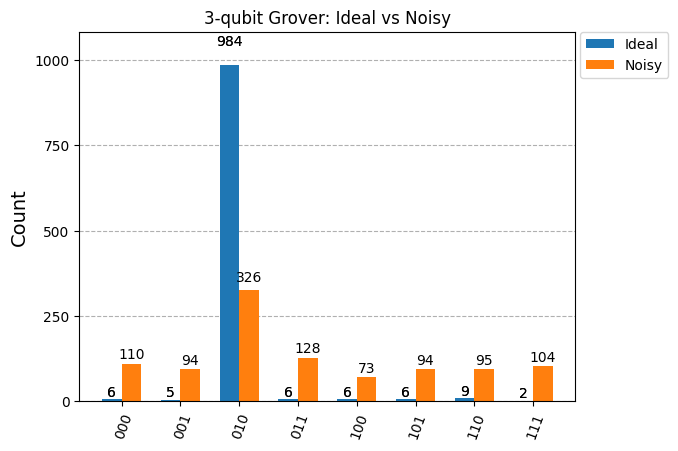

In [29]:
t_noisy_3, counts_noisy_3, succ_noisy_3 = run_grover_simulation(
    grover_circuit_3, target_state_3, noisy_sim, shots=shots
)

print("=== 3-qubit Grover: Ideal vs Noisy ===")
print(f"Noisy time: {t_noisy_3*1000:.4f} ms, success={succ_noisy_3:.3f}")
print("Noisy counts:", counts_noisy_3)

plot_histogram(
    [counts_ideal_3, counts_noisy_3],
    legend=['Ideal', 'Noisy'],
    title="3-qubit Grover: Ideal vs Noisy"
)
plt.show()

results_summary[0].update({
    "noisy_time_ms": t_noisy_3 * 1000,
    "noisy_success": succ_noisy_3,
})

10.2


=== 4-qubit Grover: Ideal vs Noisy ===
Noisy time: 63.7782 ms, success=0.068
Noisy counts: {'1110': 53, '1111': 70, '0010': 74, '0000': 66, '1100': 67, '0101': 62, '1001': 60, '1011': 67, '0011': 62, '0111': 61, '0001': 81, '1010': 66, '1101': 76, '1000': 51, '0110': 52, '0100': 56}


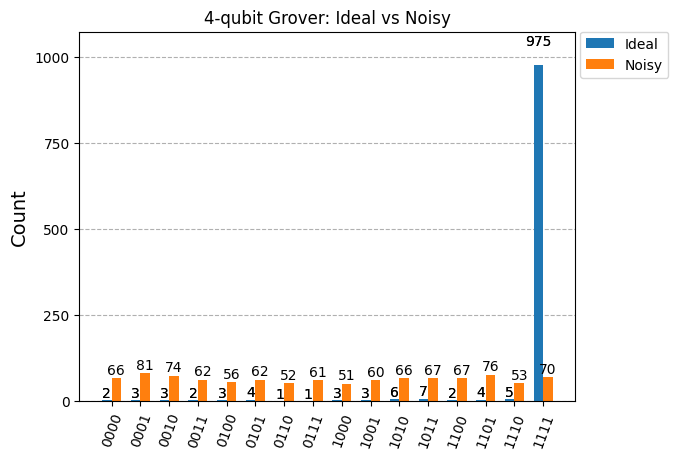

In [30]:
t_noisy_4, counts_noisy_4, succ_noisy_4 = run_grover_simulation(
    grover_circuit_4, target_state_4, noisy_sim, shots=shots
)

print("\n=== 4-qubit Grover: Ideal vs Noisy ===")
print(f"Noisy time: {t_noisy_4*1000:.4f} ms, success={succ_noisy_4:.3f}")
print("Noisy counts:", counts_noisy_4)

plot_histogram(
    [counts_ideal_4, counts_noisy_4],
    legend=['Ideal', 'Noisy'],
    title="4-qubit Grover: Ideal vs Noisy"
)
plt.show()

results_summary[1].update({
    "noisy_time_ms": t_noisy_4 * 1000,
    "noisy_success": succ_noisy_4,
})

10.3


=== 5-qubit Grover: Ideal vs Noisy ===
Noisy time: 35.0706 ms, success=0.042
Noisy counts: {'10000': 24, '01011': 29, '11000': 34, '11101': 35, '00011': 43, '00111': 33, '10101': 29, '11100': 31, '10010': 35, '10100': 47, '10111': 35, '11110': 25, '01010': 32, '11111': 38, '11011': 34, '01111': 29, '10110': 24, '10011': 39, '00101': 37, '10001': 31, '01001': 29, '11010': 28, '01100': 38, '01000': 27, '00001': 32, '00110': 38, '00010': 34, '01101': 32, '00100': 28, '01110': 25, '11001': 20, '00000': 29}


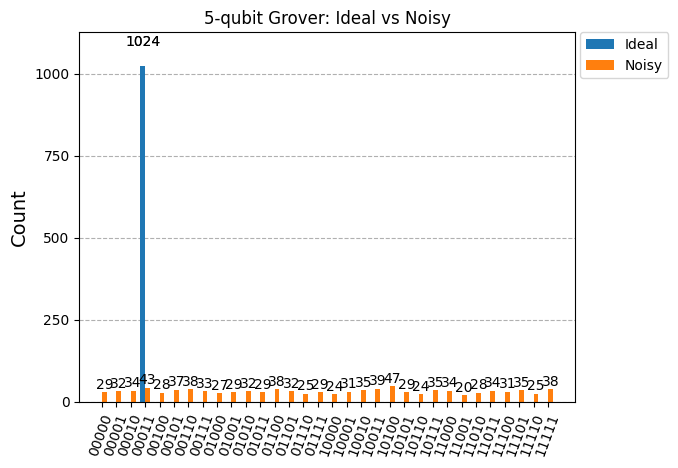

In [31]:
t_noisy_5, counts_noisy_5, succ_noisy_5 = run_grover_simulation(
    grover_circuit_5, target_state_5, noisy_sim, shots=shots
)

print("\n=== 5-qubit Grover: Ideal vs Noisy ===")
print(f"Noisy time: {t_noisy_5*1000:.4f} ms, success={succ_noisy_5:.3f}")
print("Noisy counts:", counts_noisy_5)

plot_histogram(
    [counts_ideal_5, counts_noisy_5],
    legend=['Ideal', 'Noisy'],
    title="5-qubit Grover: Ideal vs Noisy"
)
plt.show()

results_summary[2].update({
    "noisy_time_ms": t_noisy_5 * 1000,
    "noisy_success": succ_noisy_5,
})

In [32]:
df_results = pd.DataFrame(results_summary)
print(df_results)


   num_qubits   N  classical_checks  classical_time_ms  ideal_time_ms  \
0           3   8                 3           0.005381     178.343761   
1           4  16                16           0.013520      92.645237   
2           5  32                25           0.016950      97.231772   

   ideal_success  noisy_time_ms  noisy_success  
0       0.960938      36.675765       0.318359  
1       0.952148      63.778169       0.068359  
2       1.000000      35.070640       0.041992  
